In [1]:
import glob
import os
import numpy as np
from scipy.io import loadmat

def import_data_signal(root, train_ratio=0.6):
    signals = []
    labels = []
    snr_values = []


    for label_dir, label in [('signal1', 1), ('signal0', 0)]:
        full_dir = os.path.join(root, label_dir)
        if not os.path.exists(full_dir):
            print(f"Directory {full_dir} does not exist.")
            continue


        for filepath in glob.glob(os.path.join(full_dir, '*.mat')):
            try:

                mat_data = loadmat(filepath)


                if 'feature' in mat_data:  
                    signal = mat_data['feature'] 
                else:
                    raise KeyError(f"'feature' key not found in {filepath}. Available keys: {mat_data.keys()}")


                signal = np.array(signal, dtype=np.float32).reshape(64, 4, 1)
                signals.append(signal)
                labels.append(label)

       
                filename = os.path.basename(filepath)  
                snr_str = filename.split('_')[1]  
                snr = float(snr_str)  
                snr_values.append(snr)
            except Exception as e:
                print(f"Error loading {filepath}: {e}")

    print(f"Found {len(signals)} signal files.")

    if len(signals) == 0:
        raise ValueError("No signal files found. Check if the directories are correctly named and contain files.")


    combined = list(zip(signals, labels, snr_values))
    np.random.shuffle(combined)
    signals[:], labels[:], snr_values[:] = zip(*combined)


    num_samples = len(signals)
    num_train = int(train_ratio * num_samples)

    train_images = np.array(signals[:num_train])
    train_labels = np.array(labels[:num_train])
    train_snr = np.array(snr_values[:num_train])  

    test_images = np.array(signals[num_train:])
    test_labels = np.array(labels[num_train:])
    test_snr = np.array(snr_values[num_train:])  


    class_list = [0, 1] 
    return train_images, train_labels, train_snr, test_images, test_labels, test_snr, class_list


root_dir = 'C:\\Users\\yoyo2\\OneDrive\\桌面\專題\\gl\\dataset'


train_images, train_labels, train_snr, test_images, test_labels, test_snr, class_list = import_data_signal(root_dir)

print(f"Training set size: {len(train_images)}, SNR size: {len(train_snr)}")
print(f"Test set size: {len(test_images)}, SNR size: {len(test_snr)}")

Found 5200 signal files.
Training set size: 3120, SNR size: 3120
Test set size: 2080, SNR size: 2080


In [2]:
print(train_images.shape)
print(test_images.shape)
print(train_labels.shape)
print(test_labels.shape)
print(class_list)

(3120, 64, 4, 1)
(2080, 64, 4, 1)
(3120,)
(2080,)
[0, 1]


In [5]:
import numpy as np 
import cv2
import time

from framework.layer import *
from framework.utli import *
from framework.pixelhop import *
from framework.data import *
from framework.LAG import LAG_Unit

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances
from skimage.measure import block_reduce

def myModel(x, getK=1):
    x1 = PixelHop_Unit(x, dilate=1, pad='reflect', num_AC_kernels=9, weight_name='pixelhop1.pkl', getK=getK)

    # x2 = PixelHop_Unit(x1, dilate=2, pad='reflect', num_AC_kernels=25, weight_name='pixelhop2.pkl', getK=getK)
    # x2 = AvgPooling(x2)

    # x3 = PixelHop_Unit(x2, dilate=2, pad='reflect', num_AC_kernels=35, weight_name='pixelhop3.pkl', getK=getK)
    # x3 = AvgPooling(x3)

    # x4 = PixelHop_Unit(x3, dilate=2, pad='reflect', num_AC_kernels=55, weight_name='pixelhop4.pkl', getK=getK)

    # x2 = myResize(x2, x.shape[1], x.shape[2])
    # x3 = myResize(x3, x.shape[1], x.shape[2])
    # x4 = myResize(x4, x.shape[1], x.shape[2])
    return x1
SAVE={}
train_feature=myModel(train_images, getK=1)
# train_feature=PixelHop_Unit(train_images, dilate=1, pad='reflect', num_AC_kernels=9, weight_name='pixelhop1_mnist.pkl', getK=1)
train_feature = block_reduce(train_feature, (1, 16, 4, 1), np.mean).reshape(len(train_images),-1)
train_feature_reduce=LAG_Unit(train_feature,train_labels=train_labels, class_list=class_list,
                         SAVE=SAVE,num_clusters=20,alpha=5,Train=True)
test_feature=myModel(test_images, getK=0)
# test_feature=PixelHop_Unit(test_images, dilate=1, pad='reflect', num_AC_kernels=9, weight_name='pixelhop1_mnist.pkl', getK=0)
test_feature=block_reduce(test_feature, (1, 16, 4, 1), np.mean).reshape(len(test_images),-1)
test_feature_reduce=LAG_Unit(test_feature,train_labels=None, class_list=class_list,
                     SAVE=SAVE,num_clusters=20,alpha=5,Train=False)

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
scaler=preprocessing.StandardScaler()
feature = scaler.fit_transform(train_feature_reduce)
feature_test = scaler.transform(test_feature_reduce)     

clf=SVC(kernel='linear').fit(feature, train_labels) 
##        clf=RandomForestClassifier(n_estimators=500,max_depth=5).fit(train_f, train_labels) 
start_time = time.time()
print('***** Train ACC:', accuracy_score(train_labels,clf.predict(feature)))
train_time = time.time() - start_time
start_time = time.time()
print('***** Test ACC:', accuracy_score(test_labels,clf.predict(feature_test)))
test_time = time.time() - start_time


print('Number of Data:"', 2080)
print(f"Prediction Time: {test_time:.4f} seconds")
print(f"Prediction Time pre data: {(test_time/2080):.5f} seconds")
###################################### Calculate Weight Number ####################################
def count_params_pixelhop(num_AC_kernels, input_channels=1, kernel_size=2):
    return num_AC_kernels * input_channels * (kernel_size ** 2)

def count_params_lag(num_clusters, feature_dim):
    return num_clusters * feature_dim

def count_params_svm(feature_dim):
    return feature_dim + 1

# 假設輸入參數
num_AC_kernels = 9
input_channels = 1
kernel_size = 2
num_clusters = 20
feature_dim = 36  # 假設 train_feature.shape[1] 維度

# 計算參數
pixelhop_params = count_params_pixelhop(num_AC_kernels, input_channels, kernel_size)
lag_params = count_params_lag(num_clusters, feature_dim)
svm_params = count_params_svm(feature_dim)

total_params = pixelhop_params + lag_params + svm_params

# 輸出格式化表格
print("----------------------------------------------------------------")
print("{:<20} {:<20} {:<10}".format("Layer (type)", "Output Shape", "Param #"))
print("================================================================")
print("{:<20} {:<20} {:<10}".format("PixelHop", f"[{num_AC_kernels}, {kernel_size}x{kernel_size}]", pixelhop_params))
print("{:<20} {:<20} {:<10}".format("LAG (Clustering)", f"[{num_clusters}, {feature_dim}]", lag_params))
print("{:<20} {:<20} {:<10}".format("SVM", f"[{feature_dim}, 1]", svm_params))
print("================================================================")
print(f"Total params: {total_params}")
print(f"Trainable params: {total_params}")
print(f"Non-trainable params: 0")
print("----------------------------------------------------------------")

=========== Start: PixelHop_Unit
------------------- Start: PixelHop_8_Neighbour
       <Info>        Input feature shape: (3120, 64, 4, 1)
       <Info>        dilate: 1
       <Info>        padding: reflect
       <Info>        Output feature shape: (3120, 64, 4, 9)
------------------- End: PixelHop_8_Neighbour -> using   0.029999 seconds
------------------- Start: Saab transformation
       <Info>        pixelhop_feature.shape: (3120, 64, 4, 9)
       <Info>        training_data.shape: (798720, 9)
       <Info>        Num of kernels: 9
       <Info>        Energy percent: 1.000000
       <Info>        Sample patches shape after flatten: (798720, 9)
       <Info>        Kernel shape: (9, 9)
       <Info>        Transformed shape: (798720, 9)
       <Info>        Save pca params as name: ../weight/pixelhop1.pkl
------------------- End: Saab transformation -> using   0.534000 seconds
------------------- Start: Pixelhop_fit
       <Info>        Using weight: ../weight/pixelhop1.pkl
    

C:\Users\yoyo2\anaconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Users\yoyo2\anaconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


FINISH KMEANS 0
FINISH KMEANS 1
Alpha: 5
0  Kmean training acc is: 0.7589743589743589
=========== Start: PixelHop_Unit
------------------- Start: PixelHop_8_Neighbour
       <Info>        Input feature shape: (2080, 64, 4, 1)
       <Info>        dilate: 1
       <Info>        padding: reflect
       <Info>        Output feature shape: (2080, 64, 4, 9)
------------------- End: PixelHop_8_Neighbour -> using   0.015996 seconds
------------------- Start: Pixelhop_fit
       <Info>        Using weight: ../weight/pixelhop1.pkl
       <Info>        Transformed feature shape: (2080, 64, 4, 9)
------------------- End: Pixelhop_fit -> using   0.044002 seconds
       <Info>        Output feature shape: (2080, 64, 4, 9)
=========== End: PixelHop_Unit -> using   0.063997 seconds
--------Testing--------
***** Train ACC: 0.8419871794871795
***** Test ACC: 0.8384615384615385
Number of Data:" 2080
Prediction Time: 0.2110 seconds
Prediction Time pre data: 0.00010 seconds
-------------------------------

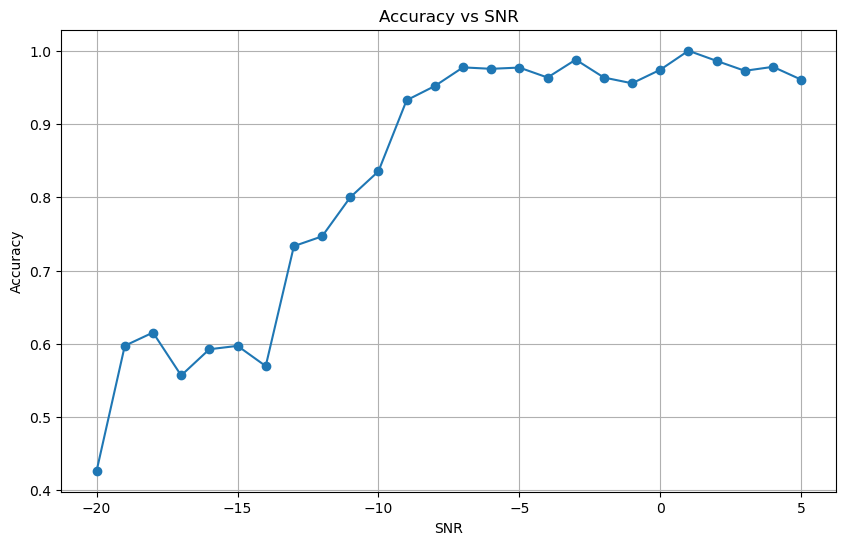

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def calculate_accuracy_by_snr(test_labels, test_snrs, predictions):
    unique_snrs = np.unique(test_snrs)
    accuracies = []

    for snr in unique_snrs:
        mask = (test_snrs == snr)
        correct = np.sum(predictions[mask] == test_labels[mask])
        total = np.sum(mask)
        accuracy = correct / total if total > 0 else 0
        accuracies.append(accuracy)

    return unique_snrs, accuracies


test_predictions = clf.predict(feature_test)


unique_snrs, accuracies = calculate_accuracy_by_snr(test_labels, test_snr, test_predictions)

def plot_accuracy_by_snr(snrs, accuracies):
    plt.figure(figsize=(10, 6))
    plt.plot(snrs, accuracies, marker='o')
    plt.title("Accuracy vs SNR")
    plt.xlabel("SNR")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.show()

plot_accuracy_by_snr(unique_snrs, accuracies)